Coordenadas polares

$$x_1 = r \cos\phi \tag{1}$$
$$x_2 = r \sin\phi \tag{2}$$

where, $ r=\sqrt{(x_1^2 + x_2^2)}, \quad \phi= \arctan\left(\frac{x_2}{x_1}\right)$

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [52]:
def oscillator2d(A, B, omega, Omega, C, t, gamma):
    """
    Simula o movimento de um oscilador harmônico amortecido subamortecido (under-damped) em 2D usando coordenadas polares.
    
    Args:
    A (float): Amplitude da oscilação na direção radial.
    B (float): Amplitude secundária na direção radial.
    omega (float): Frequência angular do oscilador.
    Omega (float): Frequência angular associada à componente angular \dot{\theta}.
    C (float): Constante de integração para a componente angular.
    t (numpy array): Array de instantes de tempo para os quais queremos calcular o movimento.
    gamma (float): Coeficiente de amortecimento.

    """
    # Calcular omega_d (frequência angular amortecida)
    omega_r = np.sqrt(omega**2 - Omega**2)
    omega_d = np.sqrt(omega_r**2 - (gamma**2 / 4))
    
    # Calcular r(t) com amortecimento
    r = (A * np.exp(-gamma * t / 2) * np.cos(omega_d * t) + 
         B * np.exp(-gamma * t / 2) * np.sin(omega_d * t))
    
    # Calcular theta(t)
    theta = C * np.cumsum(1 / r**2) * (t[1] - t[0])
    
    # Converter para coordenadas cartesianas
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    
    return r, theta, x, y


class fcn(nn.Module):
    """Defines a connected network
    """
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        """Initializes the network
        Args:
            n_input (int): number of inputs
            n_output (int): number of outputs
            n_hidden (int): number of hidden neurons
            n_layers (int): number of layers
        """
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(n_input, n_hidden), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(n_hidden, n_hidden), activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_hidden, n_output)

    def forward (self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


def save_gif_PIL(outfile, files, fps=5, loop=0):
    """Function for saving GIFs

    Args:
        outfile (gif): output file
        files (png): images to be saved
        fps (int, optional): frame rate. Defaults to 5.
        loop (int, optional): Defaults to 0.
    """
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


def plot_result(x, y, x_data, y_data, yh, xp=None):
    """Pretty plot training results

    Args:
        x (torch.tensor): input
        y (torch.tensor): output
        x_data (torch.tensor): slice of input
        y_data (torch.tensor): slice of output
        yh (torch.tensor): neural network prediction
        xp (torch.tensor, optional): optional tensor for physics loss training locations. Defaults to None.
    """
    plt.figure(figsize = (8,4))
    plt.plot(x, y, label='Analytical solution', linestyle='--', color='tab:grey', alpha=0.8)
    plt.plot(x, yh, label='Neural network prediction', linewidth=4, color='tab:blue', alpha=0.8)
    plt.scatter(x_data, y_data, label='Training data', s=60, alpha=0.4, color='tab:red')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations', s=60, alpha=0.4, color="tab:green" )
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.axis('off')

In [50]:
5*T

5.773502637713913

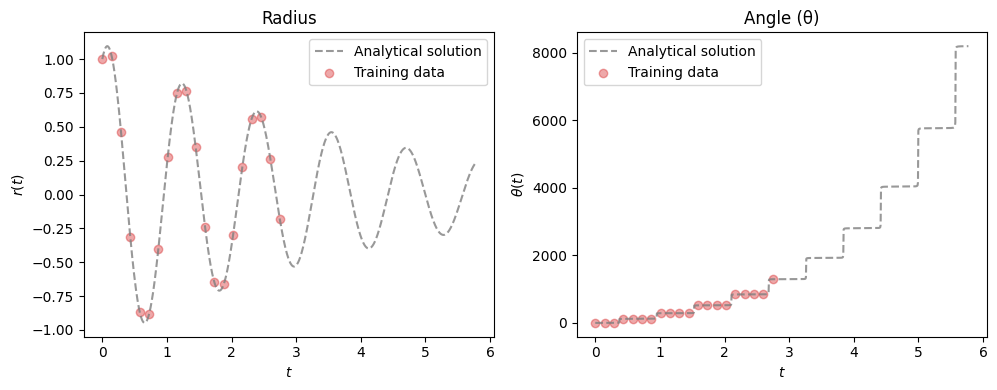

In [63]:
# Analytical solution
A = 1.0
B = 0.5
C = 1.0
omega = 2.0 * torch.acos(torch.Tensor([-1]))
Omega = 1.0 * torch.acos(torch.Tensor([-1]))
gamma = 0.5  # Coeficiente de amortecimento

# Calcular omega_r
omega_r = torch.sqrt(omega**2 - Omega**2)
# Determinar o período de uma oscilação completa
T = 2 * np.pi / omega_r.item()

# Ajustar o intervalo de tempo para capturar apenas uma oscilação completa
t = torch.linspace(0, 5*T, 1000).view(-1, 1)

r, theta, x1, x2 = oscillator2d(A, B, omega, Omega, C, t, gamma)

# Slice of points for training
t_data = t[0:500:25]
r_data = r[0:500:25]
theta_data = theta[0:500:25]

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(t.numpy(), r.numpy(), label='Analytical solution', linestyle='--', color='tab:gray', alpha=0.8)
plt.scatter(t_data.numpy(), r_data.numpy(), label='Training data', color='tab:red', alpha=0.4)
plt.title('Radius')
plt.xlabel('$t$')
plt.ylabel('$r(t)$')
plt.legend()

plt.subplot(132)
plt.plot(t.numpy(), theta.numpy(), label='Analytical solution', linestyle='--', color='tab:gray', alpha=0.8)
plt.scatter(t_data.numpy(), theta_data.numpy(), label='Training data', color='tab:red', alpha=0.4)
plt.title('Angle (θ)')
plt.xlabel('$t$')
plt.ylabel('$θ(t)$')
plt.legend()

plt.tight_layout()
plt.show()

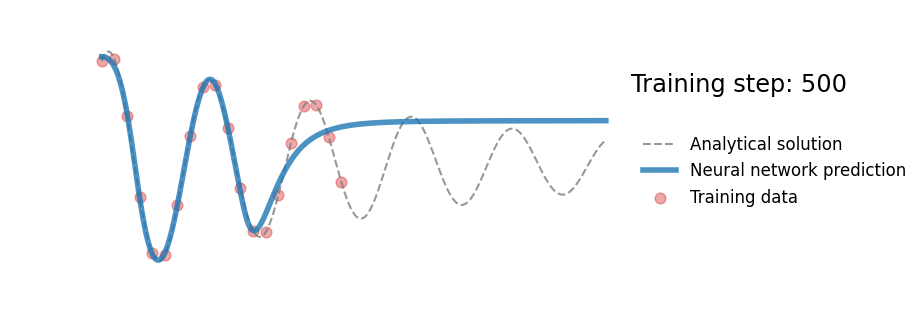

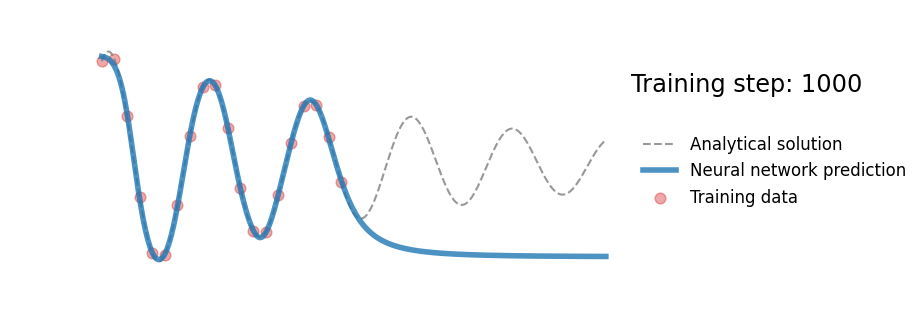

In [64]:
torch.manual_seed(42)
model = fcn(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    r_pred = model(t_data)
    loss = nn.MSELoss()(r_pred, r_data)

    loss.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
        r_pred = model(t).detach()
        plot_result(t, r, t_data, r_data, r_pred)
        file = 'plots/nn2d_%.4i.png'%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
        files.append(file)

        if (i+1) % 500 == 0:
            plt.xlim(-1.05, 6.05)
            plt.ylim(-1.5, 1.5)
            plt.text(6.065, 0.7, 'Training step: %i'%(i+1), fontsize='xx-large',color='k')
            plt.show()
        else:
            plt.close('all')

In [66]:
t_phy = torch.linspace(0,5*T,30).view(-1,1).requires_grad_(True)

torch.manual_seed(42)
model = fcn(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

files = []
for i in range(20000):
    optimizer.zero_grad()
    